## Assignment: Multiple Assumptions

Use the model specified below and check the following assumptions:

1. Assess Linearity & fix if necessary
2. Assess Independence of Errors -- if violated stop here
3. Assess Normality of Errors & fix if necessary
4. Assess Multicollinearity & fix if necessary
5. Assess Equal Variance of Errors & fix if necessary
6. Determine if any influential points are in our data and fix if necessary

In [1]:
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import numpy as np

computers = pd.read_csv("../Data/Computers.csv")

computers.tail()

,price,speed,hd,ram,screen,cd,multi,premium,ads,trend
6254,1690,100,528,8,15,no,no,yes,39,35
6255,2223,66,850,16,15,yes,yes,yes,39,35
6256,2654,100,1200,24,15,yes,no,yes,39,35
6257,2195,100,850,16,15,yes,no,yes,39,35
6258,2490,100,850,16,17,yes,no,yes,39,35


In [2]:
computers.corr(numeric_only=True)

,price,speed,hd,ram,screen,ads,trend
price,1.000000,0.300976,0.430258,0.622748,0.296041,0.054540,-0.199987
speed,0.300976,1.000000,0.372304,0.234760,0.189074,-0.215232,0.405438
hd,0.430258,0.372304,1.000000,0.777726,0.232802,-0.323222,0.577790
ram,0.622748,0.234760,0.777726,1.000000,0.208954,-0.181670,0.276844
screen,0.296041,0.189074,0.232802,0.208954,1.000000,-0.093919,0.188614
ads,0.054540,-0.215232,-0.323222,-0.181670,-0.093919,1.000000,-0.318553
trend,-0.199987,0.405438,0.577790,0.276844,0.188614,-0.318553,1.000000


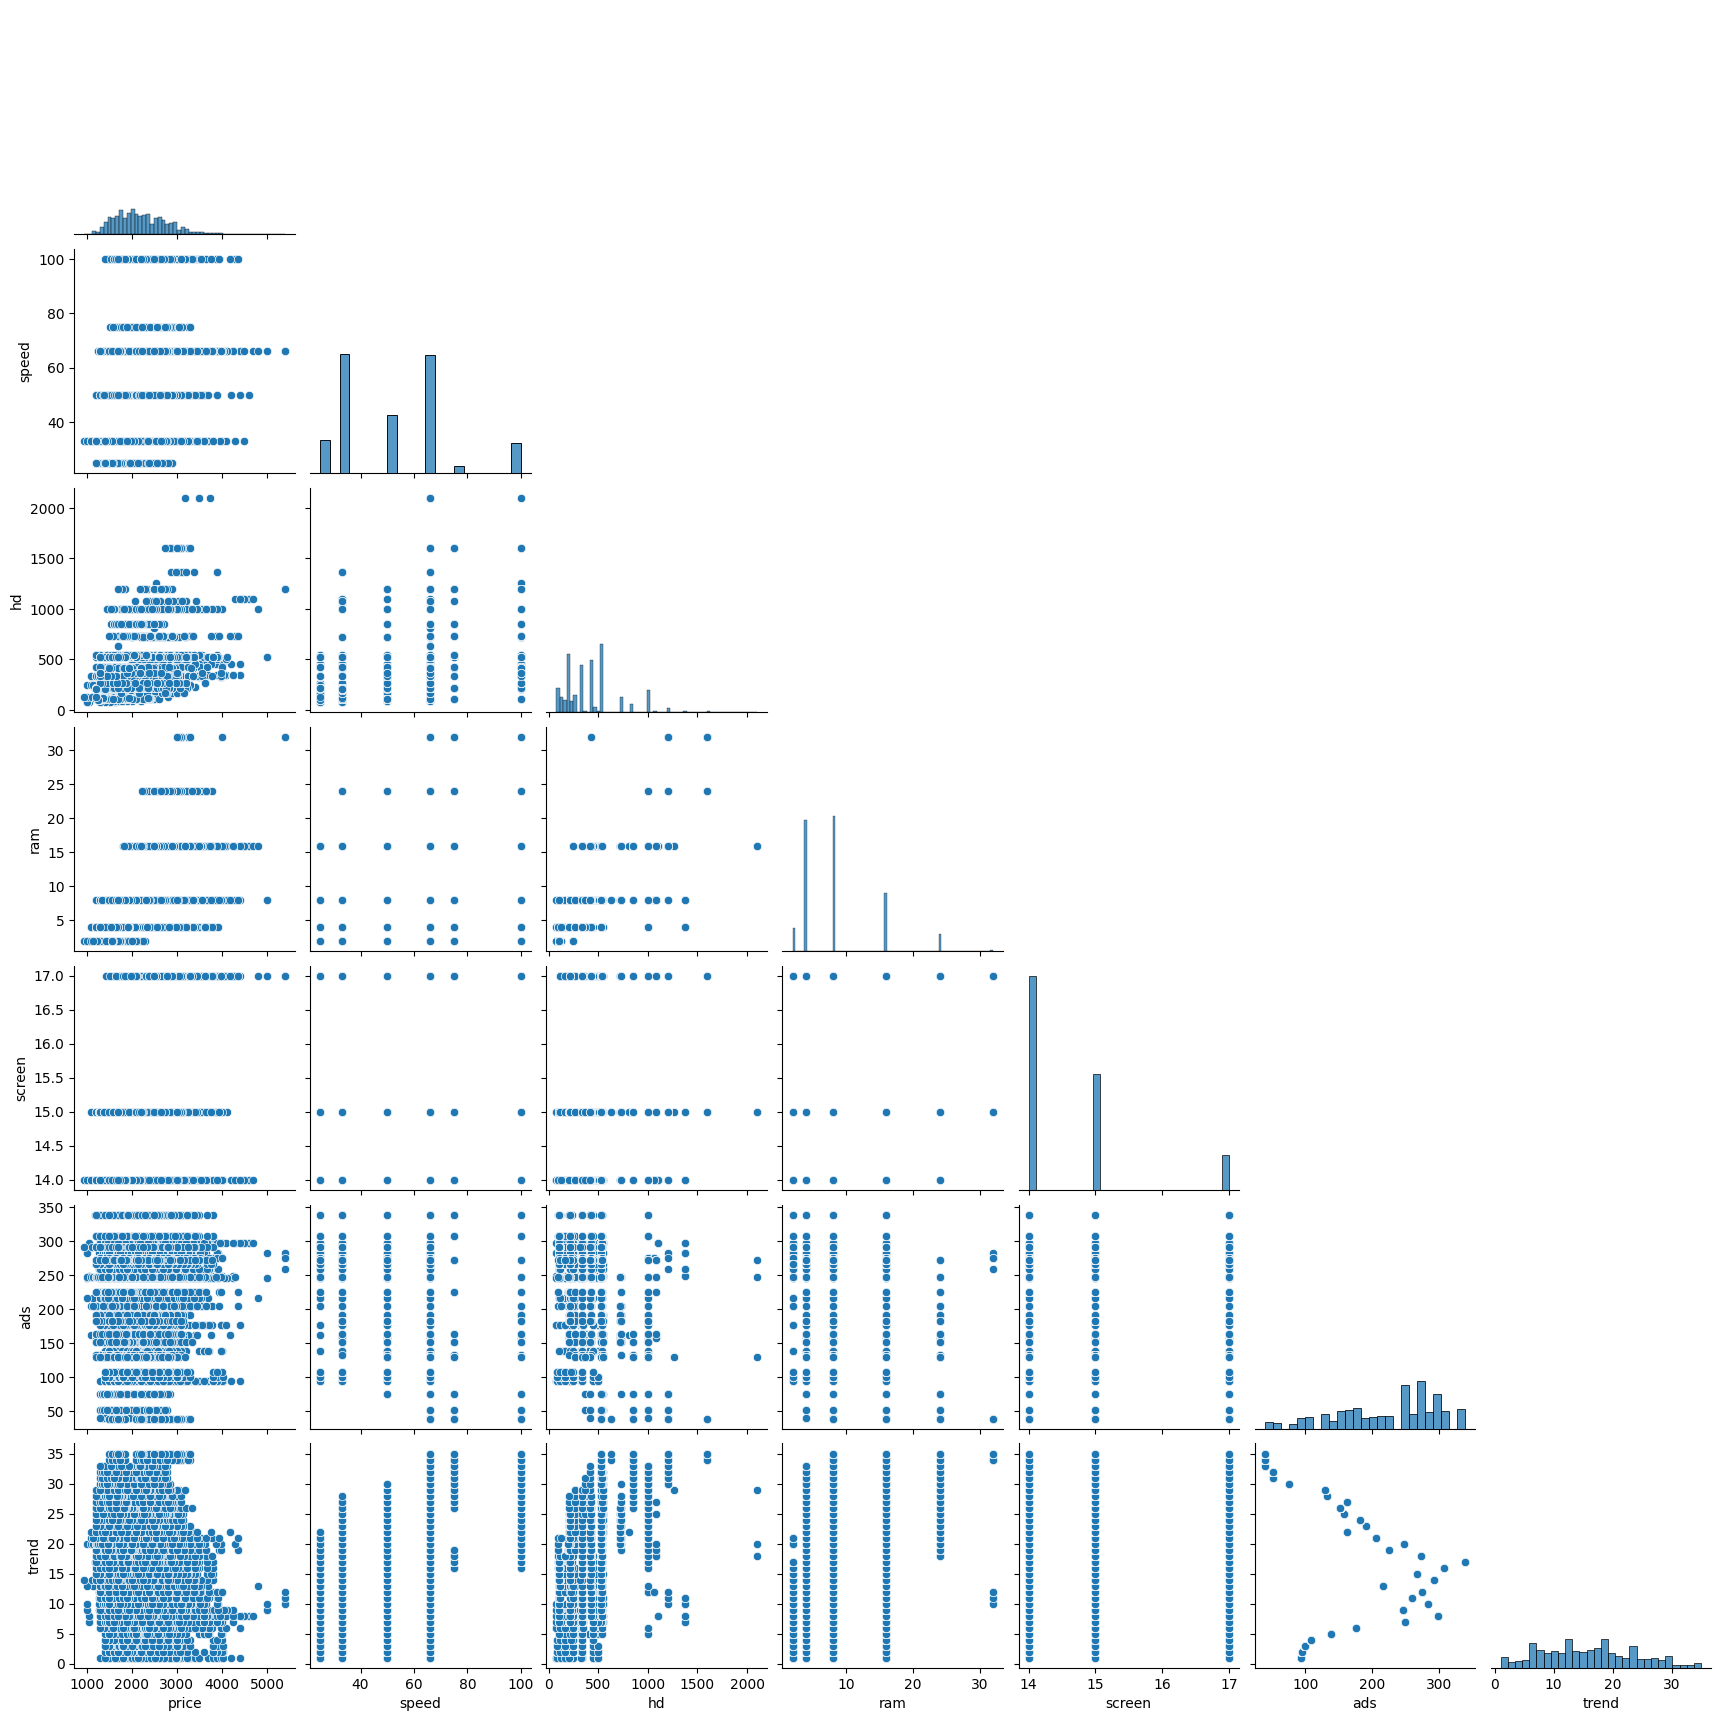

In [3]:
# Linearity - Not super clear here, but possible with some of our features
# will try fitting w/ and w/o polynomial terms

sns.pairplot(computers, corner=True)

<Axes: xlabel='ram'>

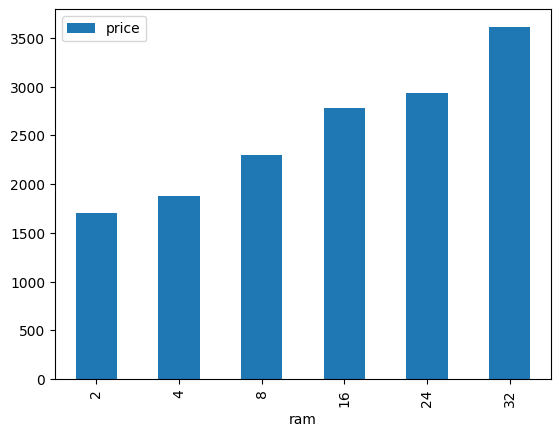

In [4]:
computers.groupby("ram").agg({"price": "mean"}).plot.bar()

### Model Fitting & Evaluation

In [5]:
# Independence - DW Test Statistic looks great

cols = ["ram", "speed", "hd", "screen", "ads", "trend"]

X = sm.add_constant(computers[cols])
y = computers["price"]

model = sm.OLS(y, X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.712
Model:                            OLS   Adj. R-squared:                  0.712
Method:                 Least Squares   F-statistic:                     2580.
Date:                Tue, 04 Nov 2025   Prob (F-statistic):               0.00
Time:                        15:49:26   Log-Likelihood:                -44817.
No. Observations:                6259   AIC:                         8.965e+04
Df Residuals:                    6252   BIC:                         8.969e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -246.6755     66.371     -3.717      0.000    -376.785    -116.566
ram           47.3870      1.188     39.899      0.000      45.059      49.715
speed          8.8939      0.209     42.590      0.000       8.485       9.303
hd             0.7088      0.031     22.932      0.000       0.648       0.769
screen       126.7024      4.521     28.022      0.000     117.839     135.566
ads            0.9697      0.057     17.099      0.000       0.859       1.081
trend        -47.0820      0.676    -69.660      0.000     -48.407     -45.757
==============================================================================
Omnibus:                     1407.073   Durbin-Watson:                   1.948
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3902.981
Skew:                           1.187   Prob(JB):                         0.00
Kurtosis:                       6.054   Cond. No.                     8.89e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.89e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [6]:
### Residual plotter helper function

def residual_analysis_plots(model):
    
    import scipy.stats as stats
    import matplotlib.pyplot as plt
    
    predictions = model.predict()
    residuals = model.resid
    
    fig, ax = plt.subplots(1, 2, sharey="all", figsize=(10, 6))
    
    sns.scatterplot(x=predictions, y=residuals, ax=ax[0], alpha=.3)
    ax[0].set_title("Residual Plot")
    ax[0].set_xlabel("Prediction")
    ax[0].set_ylabel("Residuals")
    
    stats.probplot(residuals, dist="norm", plot=ax[1])
    ax[1].set_title("Normal Q-Q Plot")   

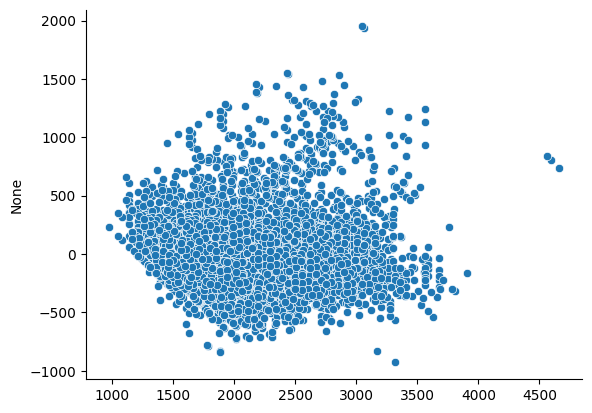

In [7]:
# looks like slight equal variance issues

sns.scatterplot(x=model.predict(), y=model.resid)

sns.despine()

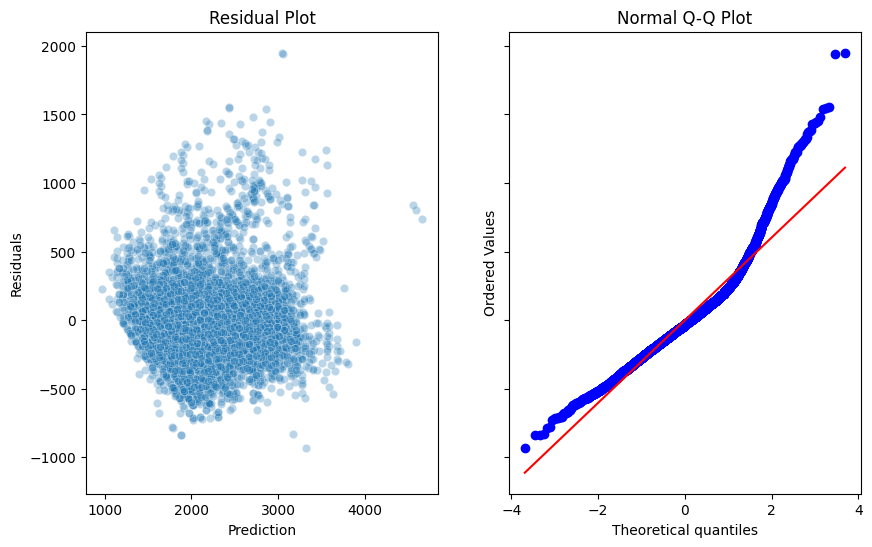

In [8]:
residual_analysis_plots(model)

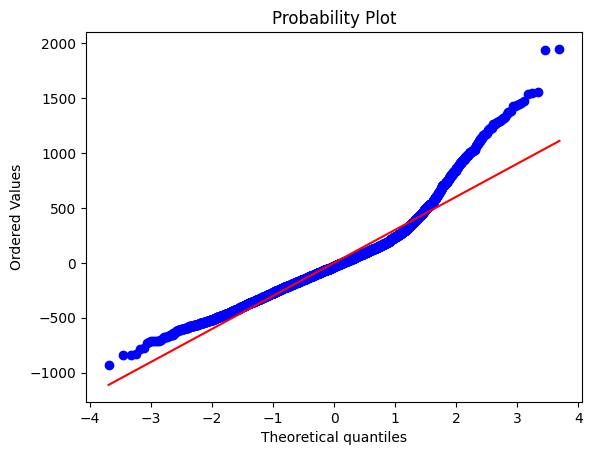

In [9]:
# Normality is violated - try a log transform

import scipy.stats as stats
import matplotlib.pyplot as plt

stats.probplot(model.resid, dist="norm", plot=plt);

### Outliers & Influence

In [10]:
influence = model.get_influence()
inf_summary_df = influence.summary_frame()
inf_summary_df.head()

,dfb_const,dfb_ram,dfb_speed,dfb_hd,dfb_screen,dfb_ads,dfb_trend,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
0,-0.026410,-0.002212,0.014571,0.009137,0.005419,0.056295,0.032299,0.000796,-1.736830,0.001845,-0.074669,-1.737110,-0.074681
1,-0.010697,0.004813,0.002294,-0.000425,0.002237,0.022722,0.016186,0.000136,-0.721759,0.001822,-0.030834,-0.721732,-0.030833
2,-0.003102,0.013793,0.022056,-0.006757,-0.022813,0.063162,0.049238,0.001159,-2.040400,0.001944,-0.090057,-2.040916,-0.090079
3,-0.022705,-0.013671,0.013052,0.011683,0.006394,0.045686,0.026238,0.000551,-1.426453,0.001890,-0.062077,-1.426572,-0.062082
4,0.023827,0.037469,-0.007201,-0.021642,-0.010694,-0.043021,-0.025814,0.000694,1.384859,0.002528,0.069717,1.384960,0.069722


In [11]:
# no influential points

inf_summary_df["cooks_d"].sort_values(ascending=False).head()

1700    0.011563
1440    0.011332
993     0.009764
1042    0.008569
1122    0.008068
Name: cooks_d, dtype: float64

### Model with feature dngineering, log transform, polynomial target

In [12]:
# Try engineering squared terms to address potential linearity issue
# and log transform target 

computers = computers.assign(
    ram2 = computers["ram"] ** 2,
    hd2 = computers["hd"] ** 2,
    premium_flag = np.where(computers["premium"] == "yes", 1, 0),
    multi_flag = np.where(computers["multi"] == "yes", 1, 0),
    cd_flag = np.where(computers["cd"] == "yes", 1, 0),
    trend2 = computers["trend"] ** 2
)

cols = [
    "ram", 
    "ram2", 
    "speed", 
    "hd", 
    "hd2", 
    "screen", 
#     "ads", 
    "trend",
    "trend2",
    "premium_flag",
    "multi_flag",
    "cd_flag"
]

X = sm.add_constant(computers[cols])
# y = computers["price"]
y = np.log(computers["price"])

model = sm.OLS(y, X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                     2332.
Date:                Tue, 04 Nov 2025   Prob (F-statistic):               0.00
Time:                        15:51:06   Log-Likelihood:                 4701.5
No. Observations:                6259   AIC:                            -9379.
Df Residuals:                    6247   BIC:                            -9298.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            6.8071      0.025    272.868      0.000       6.758       6.856
ram              0.0291      0.001     21.463      0.000       0.026       0.032
ram2            -0.0004   4.95e-05     -7.439      0.000      -0.000      -0.000
speed            0.0041   7.84e-05     52.305      0.000       0.004       0.004
hd               0.0007   2.76e-05     23.632      0.000       0.001       0.001
hd2          -2.255e-07   1.89e-08    -11.950      0.000   -2.63e-07   -1.89e-07
screen           0.0511      0.002     30.692      0.000       0.048       0.054
trend           -0.0146      0.001    -18.441      0.000      -0.016      -0.013
trend2          -0.0003   2.26e-05    -13.258      0.000      -0.000      -0.000
premium_flag    -0.2352      0.005    -45.677      0.000      -0.245      -0.225
multi_flag       0.0487      0.005     10.288      0.000       0.039       0.058
cd_flag          0.0330      0.004      8.253      0.000       0.025       0.041
==============================================================================
Omnibus:                      109.578   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              212.458
Skew:                           0.072   Prob(JB):                     7.33e-47
Kurtosis:                       3.891   Cond. No.                     7.01e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.01e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

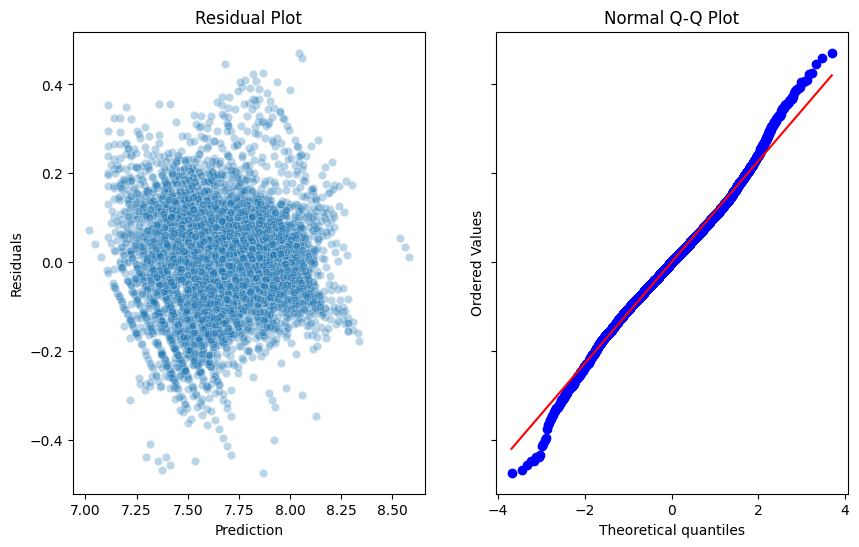

In [13]:
# Residuals look much better now, with no clear issues

residual_analysis_plots(model)

### Multicollinearity

In [14]:
# Multicollinearity looks good! VIFS all below 5, not including polynomial terms, which are exceptions

from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

variables = sm.OLS(y, X).exog

pd.Series(
    [vif(variables, i) for i in range(variables.shape[1])],
    index=X.columns
)

const           298.265635
ram              27.943240
ram2             23.935180
speed             1.318827
hd               24.467411
hd2              18.083389
screen            1.088317
trend            18.652572
trend2           18.405826
premium_flag      1.121113
multi_flag        1.290003
cd_flag           1.911046
dtype: float64